**1. Import Libraries**

In [1]:
!pip install --quiet catboost
!pip install --quiet category_encoders
!pip install --quiet japanize-matplotlib
!pip install --quiet optuna
!pip install --quiet scikit-learn
!pip install --quiet -U scikit-learn
!pip install --quiet --upgrade category_encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 37.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 48.0 MB/s eta 0:00:00


In [2]:
import glob
import japanize_matplotlib
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import seaborn as sns
import warnings
import xgboost as xgb
from catboost import CatBoostRegressor, Pool
from google.colab import drive
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, StackingClassifier, HistGradientBoostingRegressor
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold, train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder
drive.mount('/content/drive')
warnings.filterwarnings('ignore')
random_state = 42
seed = 42
test_size=0.3

/usr/local/lib/python3.12/dist-packages/sklearn/experimental/enable_hist_gradient_boosting.py:18: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


Mounted at /content/drive


**2. Install Datasets**

In [3]:
# フォルダからエクセルデータを取得
files = glob.glob('/content/drive/MyDrive/成果物/2022年子牛セリ価格/*.xlsx')
list_all = []
for file in files:
    list_all.append(pd.read_excel(file,
                                  skiprows=4,
                                  sheet_name='子牛',
                                  usecols=[1,3, 4, 5, 6, 7, 8, 9, 14, 15]).replace('_x000D_\n', ' ', regex=True).reset_index(drop=True))
df = pd.concat(list_all)
df

,個体識別番号 期待育種価,産\n次,日\n齢,性\n別,父,母の父,母の祖父,4代祖,Unnamed: 14,(千円)
0,若中,R04.01.12,NaN,NaN,若百合,美津照重,勝忠平,北国７の８,342,650
1,16264-79898,06,303,去,NaN,NaN,NaN,NaN,NaN,NaN
2,しょうこ,R04.01.19,NaN,NaN,福之姫,安福久,平茂勝,北国７の８,312,656
3,13950-57488,07,296,雌,NaN,NaN,NaN,NaN,NaN,NaN
4,榛名３４０,R04.01.18,NaN,NaN,美津照重,勝忠平,福栄,平茂勝,317,619
...,...,...,...,...,...,...,...,...,...,...
726,さきなおみ8,R03.11.01,NaN,NaN,幸紀雄,美津照重,第1花国,照神12,257,303
727,16458-62428,01,284,雌,NaN,NaN,NaN,NaN,NaN,NaN
728,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
729,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**3. Organize Datasets**

In [4]:
# 列名の変更
df.rename(columns={'個体識別番号 期待育種価':'名号/個体識別番号',
                   '産\n次':'生年月日/産次',
                   '日\n齢':'日齢',
                   '性\n別':'性別',
                   'Unnamed: 14':'体重(kg)',
                   '(千円)':'セリ価格(千円)'}, inplace=True
          )

# 同一個体牛の区別
df['区別'] = df.groupby('名号/個体識別番号').cumcount() + 1
df['名号/個体識別番号_区別'] = df['名号/個体識別番号'] + '_' + df['区別'].astype(str)

# 行と列の抽出
df = df[['名号/個体識別番号',
         '区別',
         '名号/個体識別番号_区別',
         '生年月日/産次',
         '日齢',
         '性別',
         '父',
         '母の父',
         '母の祖父',
         '4代祖',
         '体重(kg)',
         'セリ価格(千円)']
        ].dropna(how="all")

df

,名号/個体識別番号,区別,名号/個体識別番号_区別,生年月日/産次,日齢,性別,父,母の父,母の祖父,4代祖,体重(kg),セリ価格(千円)
0,若中,1.0,若中_1.0,R04.01.12,NaN,NaN,若百合,美津照重,勝忠平,北国７の８,342,650
1,16264-79898,1.0,16264-79898_1.0,06,303,去,NaN,NaN,NaN,NaN,NaN,NaN
2,しょうこ,1.0,しょうこ_1.0,R04.01.19,NaN,NaN,福之姫,安福久,平茂勝,北国７の８,312,656
3,13950-57488,1.0,13950-57488_1.0,07,296,雌,NaN,NaN,NaN,NaN,NaN,NaN
4,榛名３４０,1.0,榛名３４０_1.0,R04.01.18,NaN,NaN,美津照重,勝忠平,福栄,平茂勝,317,619
...,...,...,...,...,...,...,...,...,...,...,...,...
723,16458-62404,1.0,16458-62404_1.0,02,303,雌,NaN,NaN,NaN,NaN,NaN,NaN
724,きよたいこう1,1.0,きよたいこう1_1.0,R03.10.14,NaN,NaN,百合白清２,実有貴,華春福,百合茂,290,511
725,16458-62411,1.0,16458-62411_1.0,01,302,雌,NaN,NaN,NaN,NaN,NaN,NaN
726,さきなおみ8,1.0,さきなおみ8_1.0,R03.11.01,NaN,NaN,幸紀雄,美津照重,第1花国,照神12,257,303


In [5]:
# データフレームdfから'名号/個体識別番号_区別', '父', '母の父', '母の祖父', '4代祖', '体重(kg)', 'セリ価格(千円)'列のデータを取得
df_1 = df.loc[:, ['名号/個体識別番号_区別',
                  '父',
                  '母の父',
                  '母の祖父',
                  '4代祖',
                  '体重(kg)',
                  'セリ価格(千円)'
                  ]
              ].dropna(thresh=5)

# データフレームdf_1の'名号/個体識別番号_区別'列の'名　　　号_○.○'という行と'個体識別番号 期待育種価_○.○'という行を削除
df_1 = df_1[~df_1['名号/個体識別番号_区別'].str.contains(r'名　　　号_\d+\.\d+|個体識別番号 期待育種価_\d+\.\d+', regex=True)]

# '名号/個体識別番号_区別'の列名を'名号_区別'に変更
df_1.rename(columns={'名号/個体識別番号_区別':'名号_区別'}, inplace=True)

df_1

,名号_区別,父,母の父,母の祖父,4代祖,体重(kg),セリ価格(千円)
0,若中_1.0,若百合,美津照重,勝忠平,北国７の８,342,650
2,しょうこ_1.0,福之姫,安福久,平茂勝,北国７の８,312,656
4,榛名３４０_1.0,美津照重,勝忠平,福栄,平茂勝,317,619
6,鈴広_1.0,鈴音,芳之国,安茂勝,福桜 (宮崎),361,633
8,天勝４７３_1.0,福華１,茂洋,勝忠平,安糸福,280,507
...,...,...,...,...,...,...,...
718,西榛幸栄８３１６_1.0,幸忠栄,美国桜,平茂勝,安平,348,751
720,福之桜6239_1.0,福之姫,花清国,安福久,平茂勝,323,667
722,みつまるこ4_1.0,美津忠,花国安福,美津照重,忠富士,268,338
724,きよたいこう1_1.0,百合白清２,実有貴,華春福,百合茂,290,511


In [6]:
# データフレームdfから'名号/個体識別番号_区別', '生年月日/産次', '日齢', '性別'列のデータを取得
df_2 = df.loc[:, ['名号/個体識別番号_区別',
                  '生年月日/産次',
                  '日齢',
                  '性別'
                  ]
              ].dropna(thresh=4)

# データフレームdf_2の'名号/個体識別番号_区別'列の'個体識別番号 期待育種価_○.○'という行を削除
df_2 = df_2[~df_2['名号/個体識別番号_区別'].str.contains(r'個体識別番号 期待育種価_\d+\.\d+', regex=True)]

# '名号/個体識別番号_区別'の列名を'個体識別番号_区別'に変更
df_2.rename(columns={'名号/個体識別番号_区別':'個体識別番号_区別', '生年月日/産次':'産次'}, inplace=True)

df_2

,個体識別番号_区別,産次,日齢,性別
1,16264-79898_1.0,06,303,去
3,13950-57488_1.0,07,296,雌
5,13950-57471_1.0,11,297,去
7,14207-31529_1.0,05,303,去
9,16319-29838_1.0,06,262,去
...,...,...,...,...
719,16507-83169_1.0,05,308,去
721,16458-62398_1.0,01,309,去
723,16458-62404_1.0,02,303,雌
725,16458-62411_1.0,01,302,雌


In [7]:
# 名号および個体識別番号のデータをそれぞれ取得し紐づける
name = df.loc[:, '名号/個体識別番号_区別']
number = df.loc[:, '名号/個体識別番号_区別'][1:]
name_number_dic = dict(zip(name, number))

# df_1とdf_2を結合
df_1['個体識別番号_区別'] = df_1['名号_区別'].map(name_number_dic)  # df_1とname_number_dicを紐づける
edit_df = pd.merge(df_1, df_2, on='個体識別番号_区別', how='inner')

# 列の並び替え
edit_df = edit_df.reindex(columns=['名号_区別',
                                   '個体識別番号_区別',
                                   '産次',
                                   '性別',
                                   '父',
                                   '母の父',
                                   '母の祖父',
                                   '4代祖',
                                   '体重(kg)',
                                   '日齢',
                                   'セリ価格(千円)']
                          )
edit_df.head()

,名号_区別,個体識別番号_区別,産次,性別,父,母の父,母の祖父,4代祖,体重(kg),日齢,セリ価格(千円)
0,若中_1.0,16264-79898_1.0,06,去,若百合,美津照重,勝忠平,北国７の８,342,303,650
1,しょうこ_1.0,13950-57488_1.0,07,雌,福之姫,安福久,平茂勝,北国７の８,312,296,656
2,榛名３４０_1.0,13950-57471_1.0,11,去,美津照重,勝忠平,福栄,平茂勝,317,297,619
3,鈴広_1.0,14207-31529_1.0,05,去,鈴音,芳之国,安茂勝,福桜 (宮崎),361,303,633
4,天勝４７３_1.0,16319-29838_1.0,06,去,福華１,茂洋,勝忠平,安糸福,280,262,507


**4. Check on Data**

In [8]:
# edit_dfのコピーを作成
edit_df_copy = edit_df.copy()

In [9]:
# 行列数
print("Shape of the datasets:")
print(edit_df_copy.shape)

Shape of the datasets:
(3644, 11)


In [10]:
# 各列の型
print("Name and data type of each column in the dataset:")
print(edit_df_copy.dtypes)

Name and data type of each column in the dataset:
名号_区別        object
個体識別番号_区別    object
産次           object
性別           object
父            object
母の父          object
母の祖父         object
4代祖          object
体重(kg)       object
日齢           object
セリ価格(千円)     object
dtype: object


In [11]:
# 各列の欠損値
print("Number of missing values for each column in the datasets:")
print(edit_df_copy.isnull().sum())

Number of missing values for each column in the datasets:
名号_区別         0
個体識別番号_区別     0
産次            0
性別            0
父             0
母の父           0
母の祖父          0
4代祖           0
体重(kg)       62
日齢            0
セリ価格(千円)     62
dtype: int64


In [12]:
# '産次'列のETを99に、'産次'、'体重'、'日齢'、'セリ価格'を文字列から数値列に変換する関数の定義
def preprocess_columns(df, convert_columns, replace_dict=None):
    # replace_dict が指定された場合、指定された値に置き換える
    if replace_dict:
        for col, replacements in replace_dict.items():
            if col in df.columns:
                df[col] = df[col].replace(replacements, regex=True)

    # 指定した列を数値に変換する
    for col in convert_columns:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')

    return df

# ETを99に置き換える辞書の設定
replace_dict = {
    '産次': {'ET': 99}
}

# 数値に変換する列名の設定
convert_columns = ['産次', '体重(kg)', '日齢', 'セリ価格(千円)']

# '産次'列のETを99にし、'産次'・'体重'・'日齢'・'セリ価格'を文字列から数値列に変換
edit_df_copy = preprocess_columns(edit_df_copy, convert_columns, replace_dict)
edit_df_copy

,名号_区別,個体識別番号_区別,産次,性別,父,母の父,母の祖父,4代祖,体重(kg),日齢,セリ価格(千円)
0,若中_1.0,16264-79898_1.0,6,去,若百合,美津照重,勝忠平,北国７の８,342.0,303,650.0
1,しょうこ_1.0,13950-57488_1.0,7,雌,福之姫,安福久,平茂勝,北国７の８,312.0,296,656.0
2,榛名３４０_1.0,13950-57471_1.0,11,去,美津照重,勝忠平,福栄,平茂勝,317.0,297,619.0
3,鈴広_1.0,14207-31529_1.0,5,去,鈴音,芳之国,安茂勝,福桜 (宮崎),361.0,303,633.0
4,天勝４７３_1.0,16319-29838_1.0,6,去,福華１,茂洋,勝忠平,安糸福,280.0,262,507.0
...,...,...,...,...,...,...,...,...,...,...,...
3639,西榛幸栄８３１６_1.0,16507-83169_1.0,5,去,幸忠栄,美国桜,平茂勝,安平,348.0,308,751.0
3640,福之桜6239_1.0,16458-62398_1.0,1,去,福之姫,花清国,安福久,平茂勝,323.0,309,667.0
3641,みつまるこ4_1.0,16458-62404_1.0,2,雌,美津忠,花国安福,美津照重,忠富士,268.0,303,338.0
3642,きよたいこう1_1.0,16458-62411_1.0,1,雌,百合白清２,実有貴,華春福,百合茂,290.0,302,511.0


In [13]:
# '名号_区別'、'個体識別番号_区別'列を削除
edit_df_copy = edit_df_copy.drop(['名号_区別', '個体識別番号_区別'], axis=1)

# 目的変数の設定.
target_col = 'セリ価格(千円)'

# カテゴリ変数の設定
cat_cols = edit_df_copy.select_dtypes(include=['object']).columns

# 数値変数の設定
num_cols = edit_df_copy.select_dtypes(exclude=['object']).columns.drop(target_col)

# 各変数リストの表示
print("Categorical Column:", cat_cols.tolist())
print("\nNumerical Column:", num_cols.tolist())

Categorical Column: ['性別', '父', '母の父', '母の祖父', '4代祖']

Numerical Column: ['産次', '体重(kg)', '日齢']


In [14]:
# 各カテゴリ変数のユニーク数
print("Number of unique categories for each culumn in the datasets:")
for col in cat_cols:
    num_unique_cat = edit_df_copy[col].nunique()
    print(col, num_unique_cat)

Number of unique categories for each culumn in the datasets:
性別 3
父 144
母の父 193
母の祖父 179
4代祖 202


In [15]:
# 各カテゴリ変数における出現頻度TOP5の数を表示
for col in cat_cols:
    print(f"\nTop value counts in '{col}':\n{edit_df_copy[col].value_counts().head()}")


Top value counts in '性別':
性別
去    2078
雌    1561
雄       5
Name: count, dtype: int64

Top value counts in '父':
父
福之姫      588
貴隼桜      227
幸忠栄      227
百合白清２    191
茂晴花      182
Name: count, dtype: int64

Top value counts in '母の父':
母の父
安福久     656
百合茂     306
勝忠平     280
美国桜     185
美津照重    149
Name: count, dtype: int64

Top value counts in '母の祖父':
母の祖父
安福久    629
平茂勝    455
勝忠平    294
百合茂    275
安平     175
Name: count, dtype: int64

Top value counts in '4代祖':
4代祖
平茂勝      545
安平       363
北国７の８    281
勝忠平      156
安福久      139
Name: count, dtype: int64


In [16]:
# 各数値変数の歪度を表示
print("The skewness of numerical columns:")
print(edit_df_copy[num_cols].skew())

The skewness of numerical columns:
産次        1.443228
体重(kg)    1.178306
日齢        0.043072
dtype: float64


**5. Exploratory Data Analysis(EDA)**

*5-1. Categorical Column*

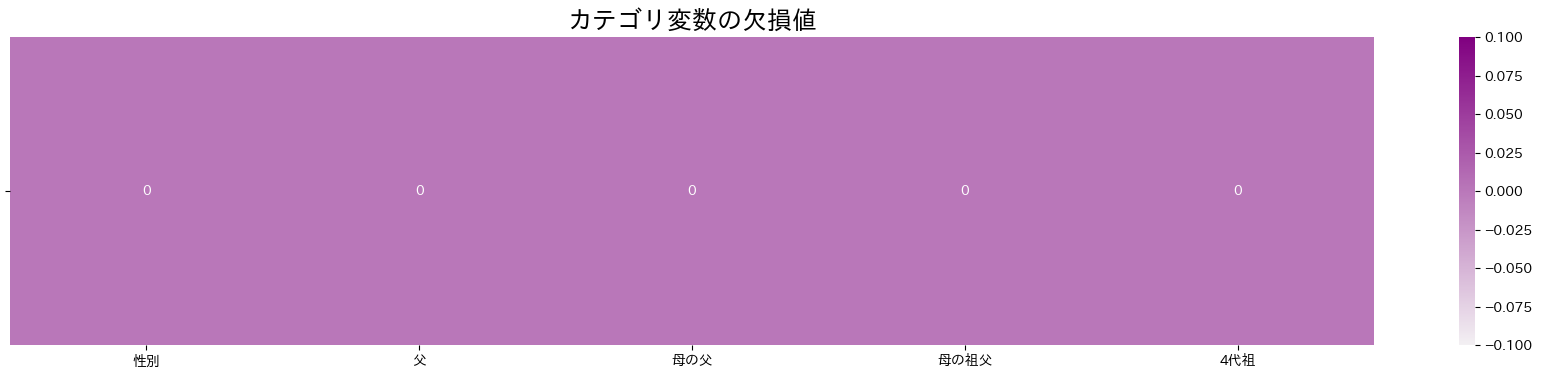

In [17]:
# ライトパレットで紫を使ってカラーマップを作成
cmap = sns.light_palette("purple", as_cmap=True)

# 欠損値のヒートマップの関数設定
def missing_value(df, dataset_name):
    plt.figure(figsize=(max(22, 11), 4))
    sns.heatmap(
        (df.isna().sum()).to_frame(name='').T,
        cmap=cmap,
        annot=True,
        fmt='0.0f'
    ).set_title(f'{dataset_name}の欠損値', fontsize=18)
    plt.show()

# カテゴリ変数の欠損値をヒートマップで表示
missing_value(edit_df_copy[cat_cols], 'カテゴリ変数')

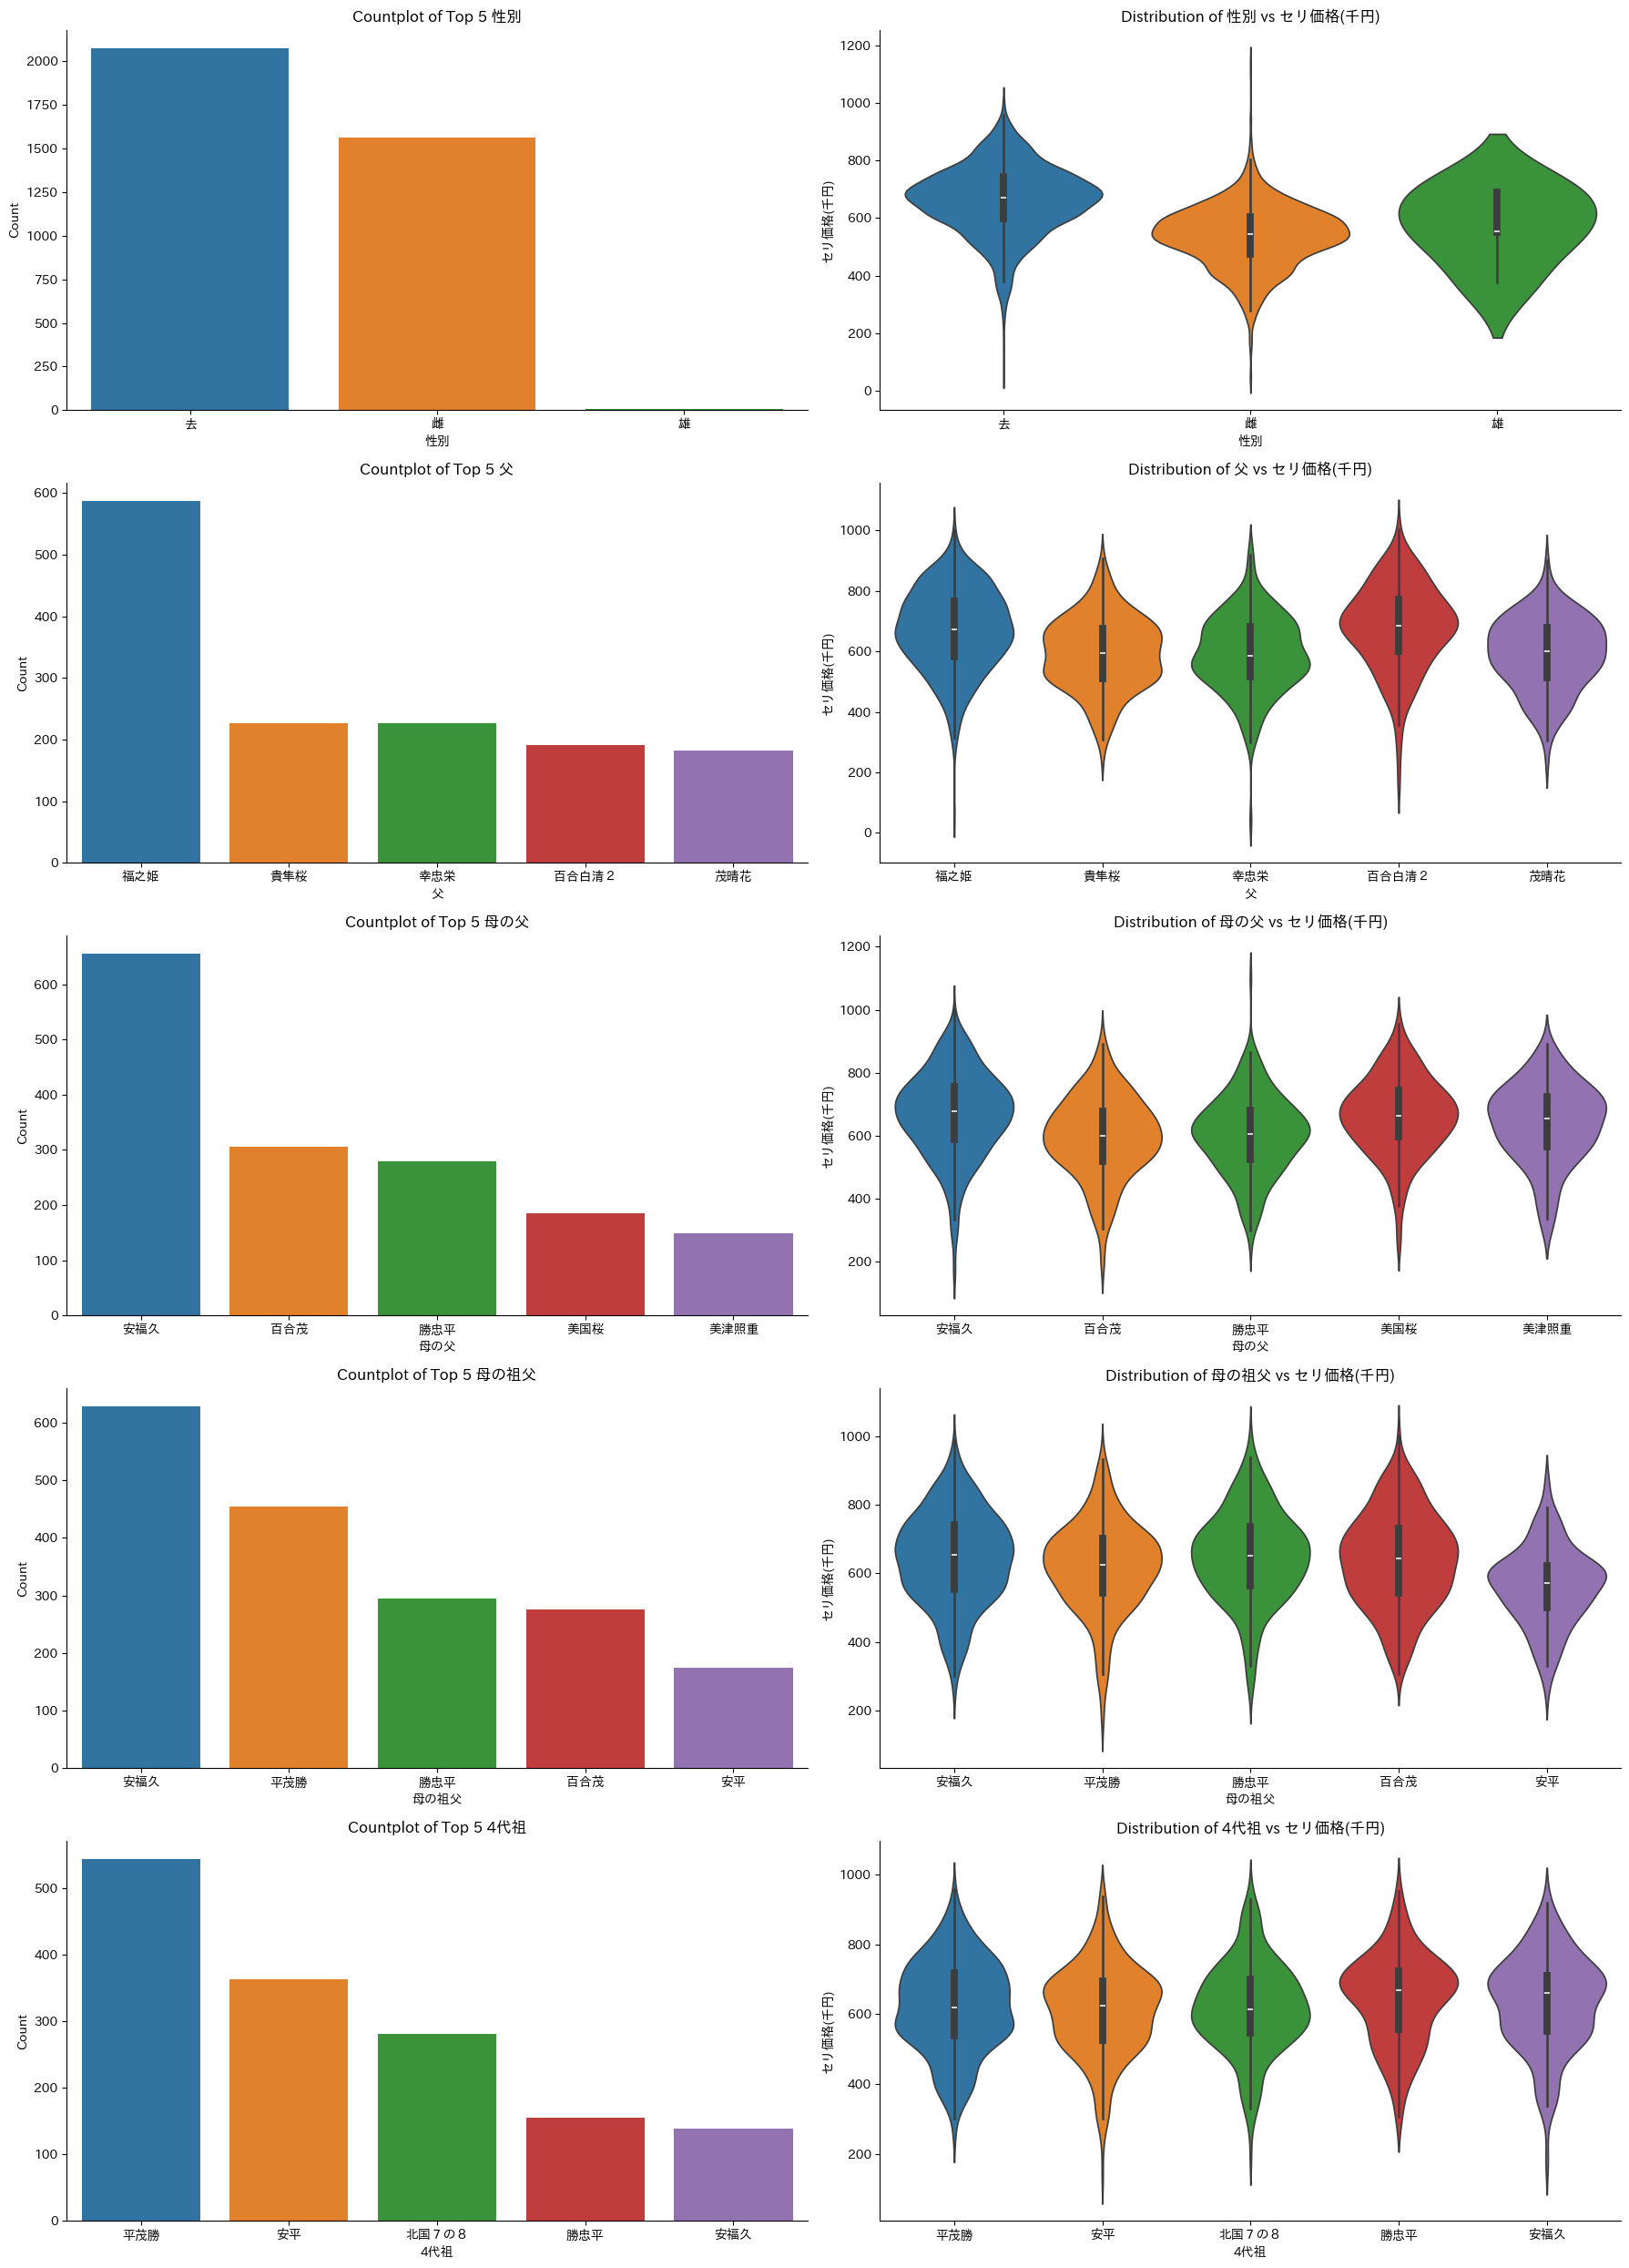

In [18]:
# 各カテゴリ変数の数をカウントプロットで、各カテゴリ変数における'セリ価格（千円）'の分布をバイオリンプロットで描出
fig, axes = plt.subplots(len(cat_cols), 2, figsize=(18, 5 * len(cat_cols)))

for i, col in enumerate(cat_cols):
    # 各カテゴリ変数の出現頻度TOP5のカテゴリを取得
    top5_values = edit_df_copy[col].value_counts().nlargest(5).index.tolist()
    filtered_top5_data = edit_df_copy[edit_df_copy[col].isin(top5_values)]

    # パレットの設定
    palette = sns.color_palette('tab10', n_colors=len(top5_values))

    # 左:カウントプロット
    sns.countplot(
        data=filtered_top5_data,
        x=col,
        order=top5_values,
        palette=palette,
        ax=axes[i, 0]
    )
    axes[i, 0].set_title(f'Countplot of Top 5 {col}')
    axes[i, 0].set_xlabel(col)
    axes[i, 0].set_ylabel('Count')

    # 右:バイオリンプロット
    sns.violinplot(
        data=filtered_top5_data,
        x=col,
        y=target_col,
        order=top5_values,
        palette=palette,
        ax=axes[i, 1]
    )
    axes[i, 1].set_title(f'Distribution of {col} vs {target_col}')
    axes[i, 1].set_xlabel(col)
    axes[i, 1].set_ylabel(target_col)

sns.despine()
plt.tight_layout()
plt.show()

*5-2. Numerical Column*

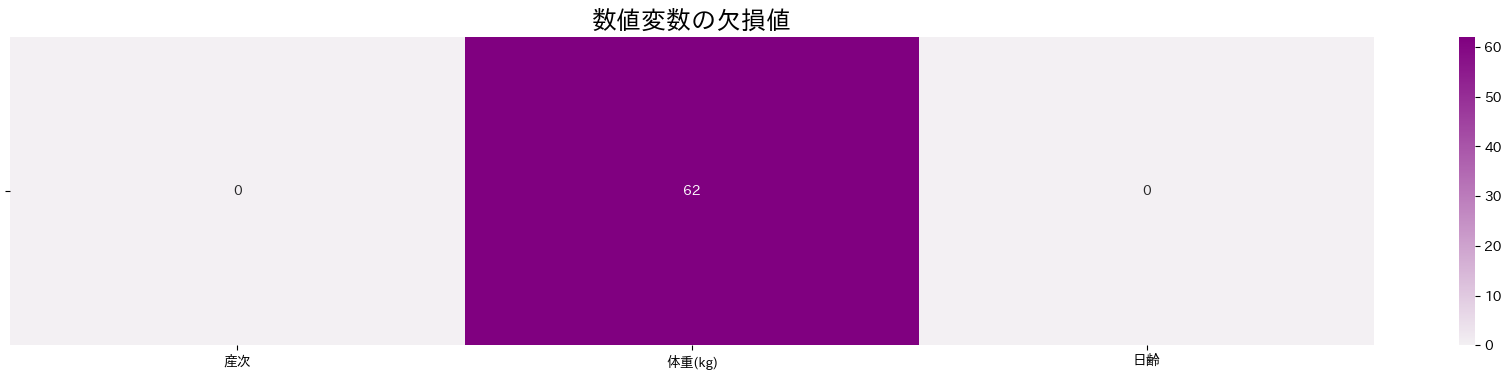

In [19]:
# 数値変数の欠損値をヒートマップで表示
missing_value(edit_df_copy[num_cols], '数値変数')

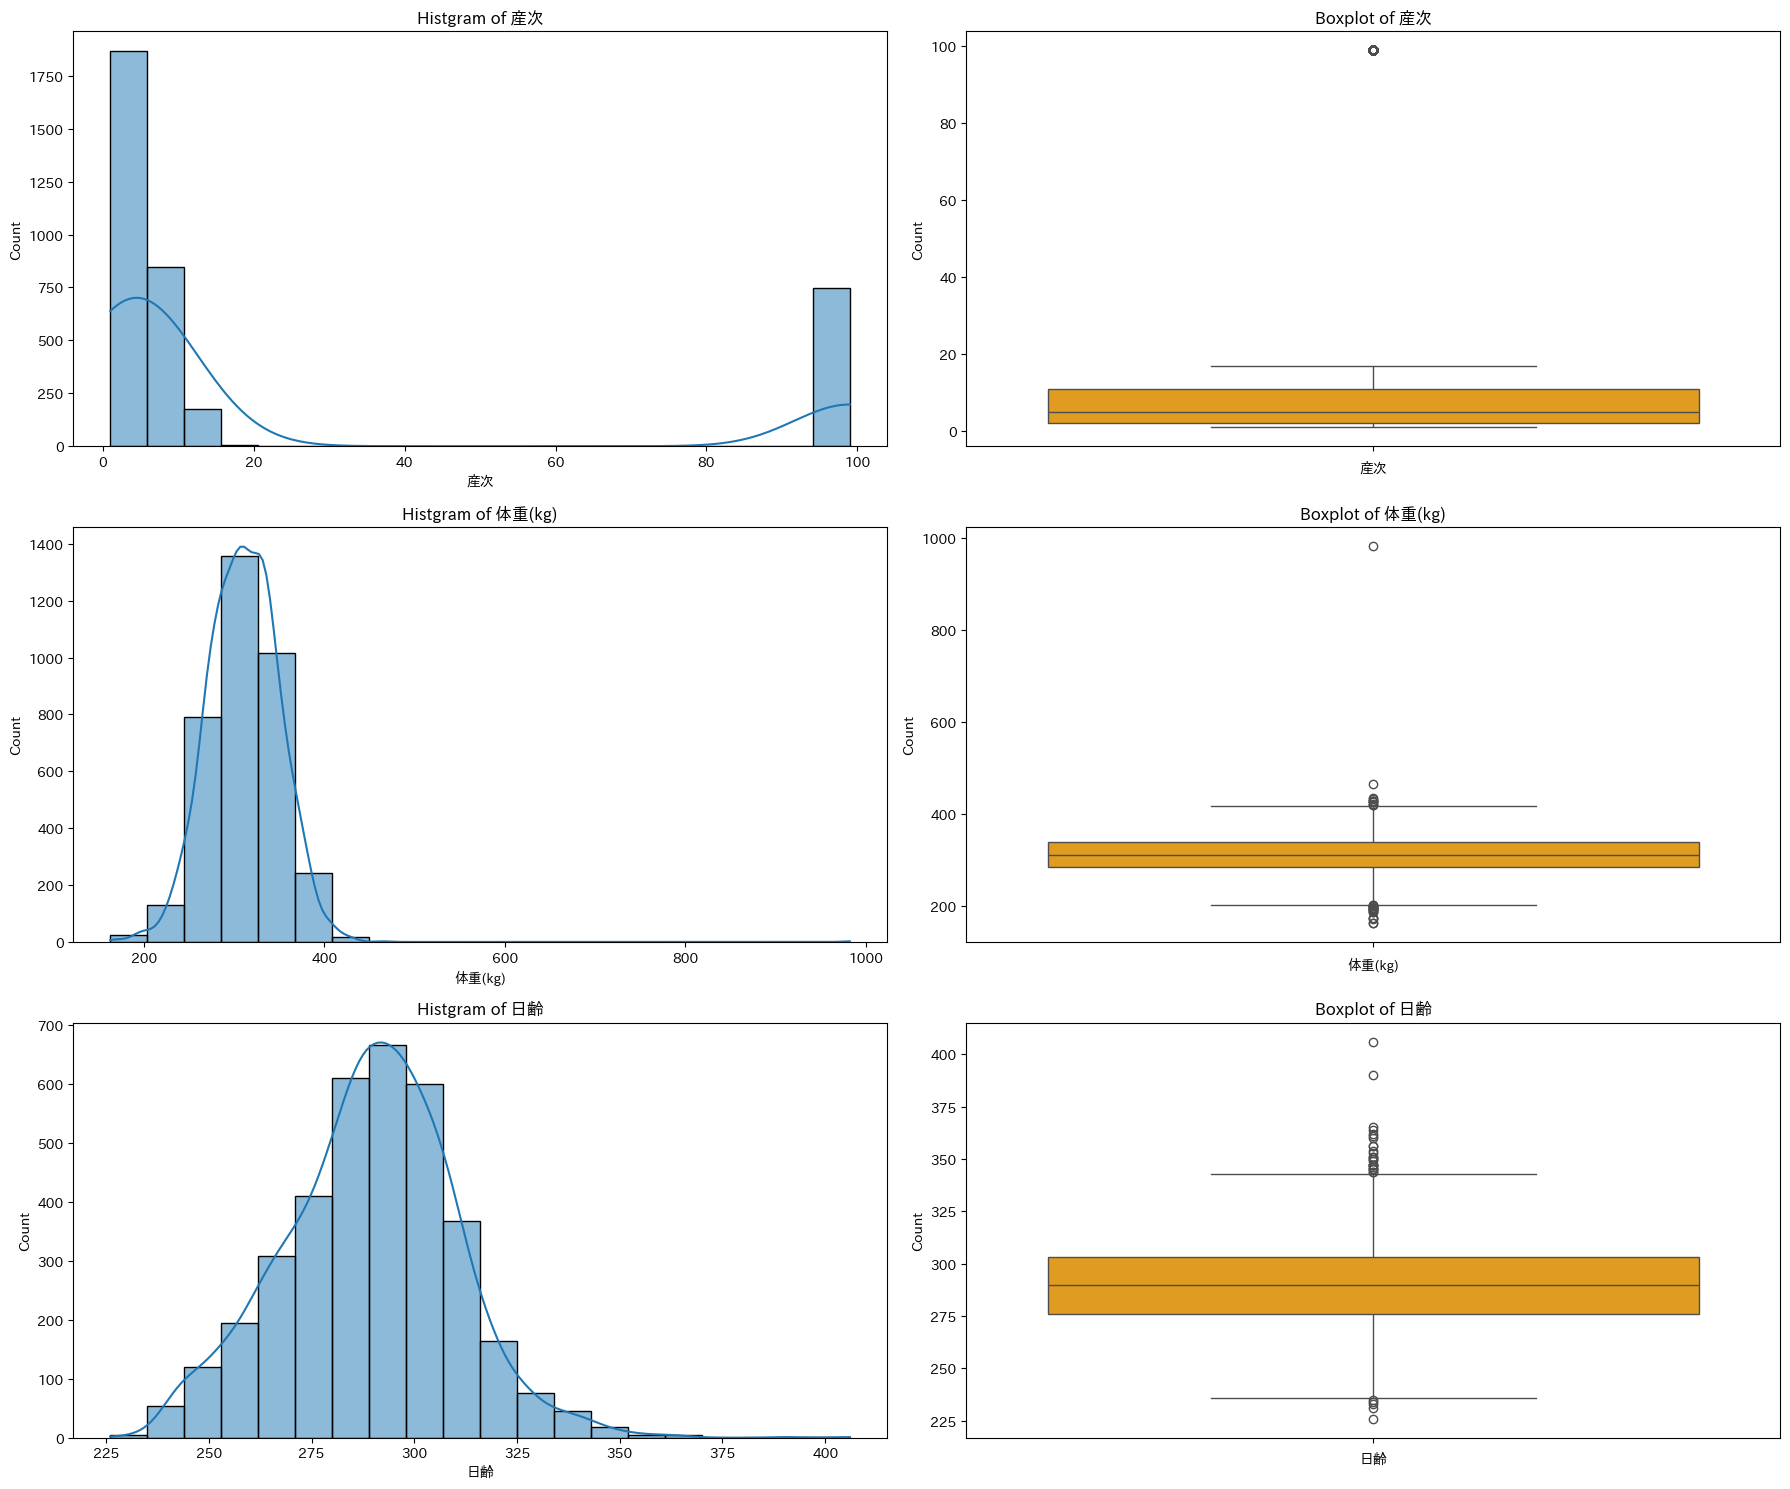

In [20]:
# 各数値変数の各階級における度数をヒストグラムで、分布をボックスプロットで抽出
fig, axes = plt.subplots(len(num_cols), 2, figsize=(18, 5 * len(num_cols)))

for i, col in enumerate(num_cols):

    # 左:ヒストグラム
    sns.histplot(
        edit_df_copy[col],
        kde=True,
        bins=20,
        ax=axes[i, 0]
        )

    axes[i, 0].set_title(f'Histgram of {col}')
    axes[i, 0].set_xlabel(col)
    axes[i, 0].set_ylabel('Count')


    # 右:ボックスプロット
    sns.boxplot(
        y=edit_df_copy[col],
        color='orange',
        ax=axes[i, 1]
        )

    axes[i, 1].set_title(f'Boxplot of {col}')
    axes[i, 1].set_xlabel(col)
    axes[i, 1].set_ylabel('Count')


plt.tight_layout()
plt.show()

*5-3. Correlation Matrix*

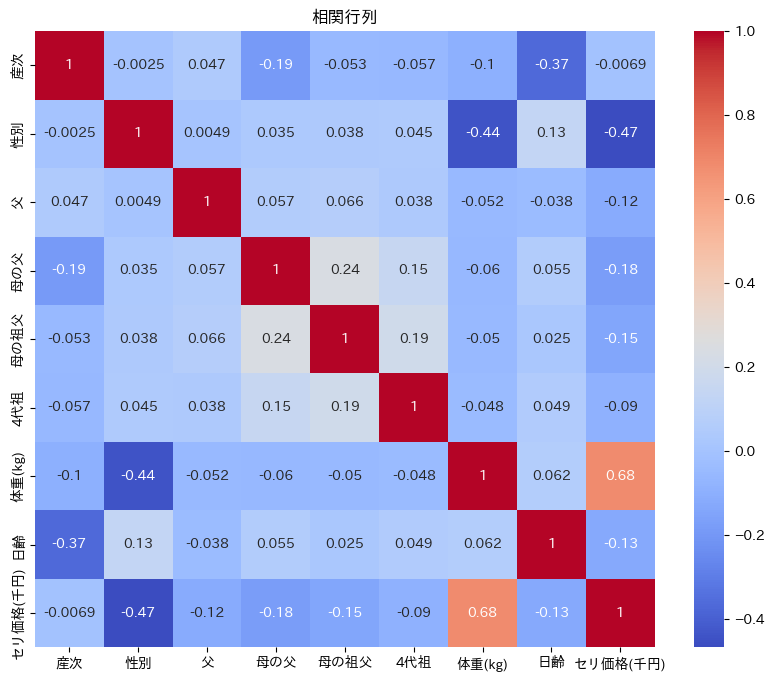

In [21]:
# 相関行列の作成
edit_df_copy_encoded = edit_df_copy.apply(lambda x: pd.factorize(x)[0] if x.dtype == 'object' else x)
correlation_matrix = edit_df_copy_encoded.corr()

correlation_matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('相関行列')
plt.show()

**6.   Data Preprocessing**

In [22]:
# 列の並び替え
edit_df_copy = edit_df_copy.reindex(
    columns=[
        '産次',
        '性別',
        '父',
        '母の父',
        '母の祖父',
        '4代祖',
        '体重(kg)',
        '日齢',
        'セリ価格(千円)'
        ]
    )

edit_df_copy

,産次,性別,父,母の父,母の祖父,4代祖,体重(kg),日齢,セリ価格(千円)
0,6,去,若百合,美津照重,勝忠平,北国７の８,342.0,303,650.0
1,7,雌,福之姫,安福久,平茂勝,北国７の８,312.0,296,656.0
2,11,去,美津照重,勝忠平,福栄,平茂勝,317.0,297,619.0
3,5,去,鈴音,芳之国,安茂勝,福桜 (宮崎),361.0,303,633.0
4,6,去,福華１,茂洋,勝忠平,安糸福,280.0,262,507.0
...,...,...,...,...,...,...,...,...,...
3639,5,去,幸忠栄,美国桜,平茂勝,安平,348.0,308,751.0
3640,1,去,福之姫,花清国,安福久,平茂勝,323.0,309,667.0
3641,2,雌,美津忠,花国安福,美津照重,忠富士,268.0,303,338.0
3642,1,雌,百合白清２,実有貴,華春福,百合茂,290.0,302,511.0


In [23]:
# 説明変数と目的変数の設定
X = edit_df_copy.drop(target_col, axis=1)
y = edit_df_copy[target_col]

# 説明変数の前処理関数の設定
def preprocessed_data(X, y):
    X_preprocessed = X.copy()
    y_preprocessed = y.copy()

    # カテゴリ変数のラベルエンコード
    cat_cols = X_preprocessed.select_dtypes(include=['object']).columns
    label_encoders = {}
    for feature in cat_cols:
        le = LabelEncoder()
        le.fit(X_preprocessed[feature])

        X_preprocessed[feature] = le.transform(X_preprocessed[feature])
        label_encoders[feature] = le

    # 新しい特徴量の作成
    X_preprocessed['体重(kg)_日齢'] = X_preprocessed['体重(kg)'] * X_preprocessed['日齢']
    X_preprocessed['体重(kg)グループ'] = pd.cut(X_preprocessed['体重(kg)'], bins=8, labels=False)
    X_preprocessed['日齢グループ'] = pd.cut(X_preprocessed['日齢'], bins=8, labels=False)

    # 欠損値の処理
    mask = y_preprocessed.notnull()
    X_preprocessed = X_preprocessed[mask]
    y_preprocessed = y_preprocessed[mask]


    return X_preprocessed, y_preprocessed, label_encoders

X_processed, y_processed, label_encoders = preprocessed_data(X, y)

In [24]:
# 説明変数と目的変数をそれぞれ学習データとテストデータに分割(7:3)
X_trainval, X_test, y_trainval, y_test = train_test_split(X_processed, y_processed, test_size=test_size, shuffle=True, random_state=random_state)

# 説明変数と目的変数の学習データをそれぞれ訓練用と検証用に分割(7:3)
X_train, X_valid, y_train, y_valid = train_test_split(X_trainval, y_trainval, test_size=test_size, shuffle=True, random_state=random_state)

**7.  Machine Learning**

*7-1.  XGBoost*

In [26]:
# Optunaのログを無効化
optuna.logging.set_verbosity(optuna.logging.WARNING)

# Optunaの準備
def xgb_objective(trial):

    # ハイパーパラメータの探索範囲を設定
    xgb_params = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'tree_method': 'hist',
        'booster': 'gbtree',
        'lambda': trial.suggest_float('lambda', 1e-8, 10.0, log=True),
        'alpha': trial.suggest_float('alpha', 1e-8, 10.0, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'eta': trial.suggest_float('eta', 0.01, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.4, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 1.0),
        'min_child_weight': trial.suggest_float('min_child_weight', 1e-3, 100.0, log=True),
        'random_state': random_state,
        'verbosity': 0,
        'early_stopping_rounds': 50,
    }

    # モデルを作成し学習
    xgb_model = xgb.XGBRegressor(**xgb_params, n_estimators=500)
    xgb_model.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        verbose=False
    )

    # 検証データを用いてモデルの評価
    y_valid_pred = xgb_model.predict(X_valid, iteration_range=(0, xgb_model.best_iteration))
    rmse = np.sqrt(mean_squared_error(y_valid, y_valid_pred))
    return rmse

# Optunaで最適ハイパーパラメータを探索
study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(xgb_objective, n_trials=150)

print('Number of finished trials:', len(study.trials))
print('Best trial:')

xgb_trial = study.best_trial
print(f'Value: {xgb_trial.value:.6f}')
print('Params: ')
for key, value in xgb_trial.params.items():
    print(f'    {key}: {value}')

Number of finished trials: 150
Best trial:
Value: 74.550244
Params: 
    lambda: 0.6024370851116627
    alpha: 0.7588984355840402
    max_depth: 6
    eta: 0.015793331149819793
    subsample: 0.7090938404690434
    colsample_bytree: 0.6203491764652311
    min_child_weight: 0.007184447304090104


In [27]:
# 最適ハイパーパラメータで再学習
xgb_best_params = xgb_trial.params
xgb_best_params.update({
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'tree_method': 'hist',
    'booster': 'gbtree',
    'random_state': random_state
})

# クロスバリデーションの準備
kf = KFold(n_splits=5, shuffle=True, random_state=random_state)

xgb_oof_predictions = np.zeros(len(X_trainval))  # 各foldの検証データに対するOOF予測値を格納
xgb_test_predictions = np.zeros(len(X_test))  # テストデータに対する予測値を格納（各foldで平均化）
xgb_best_iterations = []  # 各foldの学習された最適イテレーション数を格納

# KFoldクロスバリデーションでXGBoostモデルの学習
for fold, (train_idx, val_idx) in enumerate(kf.split(X_trainval, y_trainval)):
    X_tr, X_val = X_trainval.iloc[train_idx], X_trainval.iloc[val_idx]
    y_tr, y_val = y_trainval.iloc[train_idx], y_trainval.iloc[val_idx]

    # モデルを作成し学習
    xgb_model = xgb.XGBRegressor(**xgb_best_params, n_estimators=1000, early_stopping_rounds=50)
    xgb_model.fit(
        X_tr, y_tr,
        eval_set=[(X_val, y_val)],
        verbose=False
    )

    xgb_oof_predictions[val_idx] = xgb_model.predict(X_val)  # 検証データに対するOOF予測値を保存
    xgb_test_predictions += xgb_model.predict(X_test) / kf.n_splits  # テストデータに対する予測値を各foldで平均化
    xgb_best_iterations.append(xgb_model.best_iteration)  # 最適イテレーションを保存

# KFoldクロスバリデーションによるXGBoostのOOF予測値を用いた自由度調整済み決定係数
n = X_trainval.shape[0]  # サンプル数
k = np.sum(np.any(X_trainval.values != 0, axis=0))  # ゼロ行列ではない列をカウント
R2 = r2_score(y_trainval, xgb_oof_predictions)
adjusted_R2 = 1 - (1 - R2) * (n - 1) / (n - k - 1)
print(f"OOF Adjusted R²: {adjusted_R2:.6f}")

# 予測結果
submission = pd.DataFrame({'prediction': xgb_test_predictions})
print(submission.head())

OOF Adjusted R²: 0.655026
   prediction
0  482.920013
1  778.529343
2  560.859543
3  590.045464
4  569.265266


平均 best_iteration: 457
Best RMSE on test data: 74.39991553661085
Adjusted R-squared: 0.6438802214462767


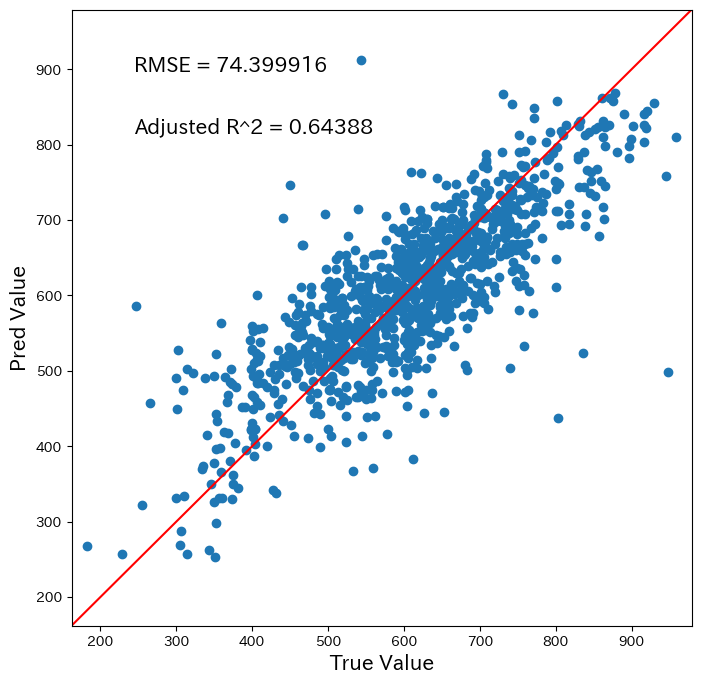

In [28]:
# 学習データ全体を用いてXGBoostモデルの再学習（モデル内部のbest_iterationを確認）
xgb_final_model = xgb.XGBRegressor(**xgb_best_params, n_estimators=10000, early_stopping_rounds=50)
xgb_final_model.fit(
    X_trainval, y_trainval,
    eval_set=[(X_trainval, y_trainval)],
    verbose=False
)

# クロスバリデーションのbest_iterationの平均値を計算
xgb_mean_best_iter = int(np.mean(xgb_best_iterations))
print(f"平均 best_iteration: {xgb_mean_best_iter}")

# 学習全体およびクロスバリデーションのbest_iterationを用いてLightGBMモデルの再学習
xgb_final_model = xgb.XGBRegressor(**xgb_best_params, n_estimators=xgb_mean_best_iter)
xgb_final_model.fit(X_trainval, y_trainval)

# テストデータを用いて予測
y_test_pred = xgb_final_model.predict(X_test)

# 予測精度を計算
xgb_rmse_best = np.sqrt(mean_squared_error(y_test, y_test_pred))

# 可視化
def True_Pred_map(pred_df):
    RMSE = np.sqrt(mean_squared_error(pred_df['true'], pred_df['pred']))
    R2 = r2_score(pred_df['true'], pred_df['pred'])

    n = len(pred_df)
    k = X_train.shape[1]
    adjusted_R2 = 1 - (1 - R2) * (n - 1) / (n - k - 1)

    print(f'Best RMSE on test data: {xgb_rmse_best}')
    print(f'Adjusted R-squared: {adjusted_R2}')

    plt.figure(figsize=(8, 8))
    ax = plt.subplot(111)
    ax.scatter('true', 'pred', data=pred_df)
    ax.set_xlabel('True Value', fontsize=15)
    ax.set_ylabel('Pred Value', fontsize=15)
    ax.set_xlim(pred_df.min().min() - 20, pred_df.max().max() + 20)
    ax.set_ylim(pred_df.min().min() - 20, pred_df.max().max() + 20)
    x = np.linspace(pred_df.min().min() - 20, pred_df.max().max() + 20, 2)
    ax.plot(x, x, 'r-')
    plt.text(0.1, 0.9, f'RMSE = {round(RMSE, 6)}', transform=ax.transAxes, fontsize=15)
    plt.text(0.1, 0.8, f'Adjusted R^2 = {round(adjusted_R2, 6)}', transform=ax.transAxes, fontsize=15)

# 予測値と真値を1つのデータフレームにまとめる
pred_df = pd.DataFrame({'true': y_test.reset_index(drop=True), 'pred': y_test_pred})

# 可視化関数の呼び出し
True_Pred_map(pred_df)

*7-2. LightGBM*

In [29]:
# Optunaの準備
def lgb_objective(trial):

    # ハイパーパラメータの探索範囲を設定
    lgb_params = {
        'objective': 'regression',
        'boosting_type': 'gbdt',
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1.0, log=True),
        'random_state': random_state,
        'verbosity': -1
    }

    # モデルを作成し学習
    lgb_model = lgb.LGBMRegressor(**lgb_params, n_estimators=1000)
    lgb_model.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        eval_metric='rmse',
        callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=False)]
    )

    # 検証データを用いてモデルの評価
    y_pred = lgb_model.predict(X_valid, num_iteration=lgb_model.best_iteration_)
    rmse = np.sqrt(np.mean((y_valid - y_pred)**2))
    return rmse

# Optunaで最適ハイパーパラメータを探索
study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=random_state))
study.optimize(lgb_objective, n_trials=50)

print("Best trial:")
print(f"  Value: {study.best_trial.value:.6f}")
print("  Params:")
for k, v in study.best_trial.params.items():
    print(f"    {k}: {v}")

Best trial:
  Value: 74.667351
  Params:
    lambda_l1: 1.0384691534702109e-08
    lambda_l2: 1.98226441299462e-07
    num_leaves: 184
    feature_fraction: 0.7499407542482138
    bagging_fraction: 0.4599147245418286
    bagging_freq: 6
    min_child_samples: 22
    learning_rate: 0.006107025253488587


In [30]:
# 最適ハイパーパラメータで再学習
lgb_best_params = study.best_trial.params
lgb_best_params.update({
    'objective': 'regression',
    'metric': 'rmse',
    'verbosity': -1,
    'random_state': random_state
})

# クロスバリデーションの準備
kf = KFold(n_splits=5, shuffle=True, random_state=random_state)

lgb_oof_predictions = np.zeros(len(X_trainval))  # 各foldの検証データに対するOOF予測値を格納
lgb_test_predictions = np.zeros(len(X_test))   # テストデータに対する予測値を格納（各foldで平均化）
lgb_best_iterations = []  # 各foldの学習された最適イテレーション数を格納

# KFoldクロスバリデーションでLightGBMモデルの学習
for train_idx, val_idx in kf.split(X_trainval, y_trainval):
    X_tr, X_val = X_trainval.iloc[train_idx], X_trainval.iloc[val_idx]
    y_tr, y_val = y_trainval.iloc[train_idx], y_trainval.iloc[val_idx]

    lgb_model = lgb.LGBMRegressor(**lgb_best_params, n_estimators=1000)
    lgb_model.fit(
        X_tr, y_tr,
        eval_set=[(X_val, y_val)],
        eval_metric='rmse',
        callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=False)] # 検証データが50回連続で改善しない場合、学習を打ち切り
    )

    lgb_oof_predictions[val_idx] = lgb_model.predict(X_val, num_iteration=lgb_model.best_iteration_)  # 検証データに対するOOF予測値を保存
    lgb_test_predictions += lgb_model.predict(X_test, num_iteration=lgb_model.best_iteration_) / kf.n_splits  # テストデータに対する予測値を各foldで平均化
    lgb_best_iterations.append(lgb_model.best_iteration_)  # 最適イテレーションを保存

# KFoldクロスバリデーションによるLightGBMのOOF予測値を用いた自由度調整済み決定係数
n = X_trainval.shape[0]  # サンプル数
k = X_trainval.shape[1]  # 特徴量数
R2 = r2_score(y_trainval, lgb_oof_predictions)
adjusted_R2 = 1 - (1 - R2) * (n - 1) / (n - k - 1)
print(f"OOF Adjusted R²: {adjusted_R2:.6f}")

# テストデータに対する予測値を出力
submission = pd.DataFrame({'prediction': lgb_test_predictions})
print(submission.head())

OOF Adjusted R²: 0.653215
   prediction
0  479.166518
1  769.923221
2  572.210539
3  594.940362
4  562.681230


平均 best_iteration: 818
Best RMSE on test data: 74.85879549761172
Adjusted R-squared: 0.6394737598526303


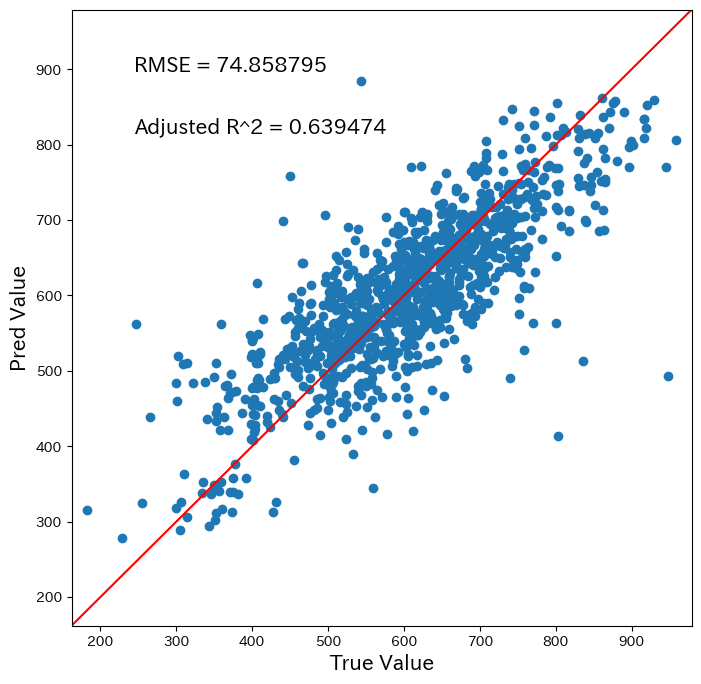

In [31]:
# 学習データ全体を用いてLightGBMモデルの再学習（モデル内部のbest_iterationを確認）
lgb_final_model = lgb.LGBMRegressor(**lgb_best_params, n_estimators=10000)
lgb_final_model.fit(
    X_trainval, y_trainval,
    eval_set=[(X_trainval, y_trainval)],
    eval_metric='rmse',
    callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=False)]  # 1000ツリー分学習するが、学習データが50回連続で改善しない場合、学習を打ち切り
)

# クロスバリデーションのbest_iterationの平均値を計算
lgb_mean_best_iter = int(np.mean(lgb_best_iterations))
print(f"平均 best_iteration: {lgb_mean_best_iter}")

# 学習全体およびクロスバリデーションのbest_iterationを用いてLightGBMモデルの再学習
lgb_final_model = lgb.LGBMRegressor(**lgb_best_params, n_estimators=lgb_mean_best_iter)
lgb_final_model.fit(X_trainval, y_trainval)

# テストデータを用いて予測
y_test_pred = lgb_final_model.predict(X_test)

# 予測精度を計算
lgb_rmse_best = np.sqrt(mean_squared_error(y_test, y_test_pred))

# 可視化関数の設定（予測値と真値およびモデルの性能を可視化）
def True_Pred_map(pred_df):
    RMSE = np.sqrt(mean_squared_error(pred_df['true'], pred_df['pred']))
    R2 = r2_score(pred_df['true'], pred_df['pred'])

    n = len(pred_df)
    k = X_train.shape[1]
    adjusted_R2 = 1 - (1 - R2) * (n - 1) / (n - k - 1)

    print(f'Best RMSE on test data: {lgb_rmse_best}')
    print(f'Adjusted R-squared: {adjusted_R2}')

    plt.figure(figsize=(8,8))
    ax = plt.subplot(111)
    ax.scatter('true', 'pred', data=pred_df)
    ax.set_xlabel('True Value', fontsize=15)
    ax.set_ylabel('Pred Value', fontsize=15)
    ax.set_xlim(pred_df.min().min()-20 , pred_df.max().max()+20)
    ax.set_ylim(pred_df.min().min()-20 , pred_df.max().max()+20)
    x = np.linspace(pred_df.min().min()-20, pred_df.max().max()+20, 2)
    y = x
    ax.plot(x, y, 'r-')
    plt.text(0.1, 0.9, 'RMSE = {}'.format(str(round(RMSE, 6))), transform=ax.transAxes, fontsize=15)
    plt.text(0.1, 0.8, 'Adjusted R^2 = {}'.format(str(round(adjusted_R2, 6))), transform=ax.transAxes, fontsize=15)

# 予測値と真値をpandas.Seriesに変換
y_test_series = pd.Series(y_test, name='true')
y_test_pred_series = pd.Series(y_test_pred, name='pred')

# 予測値と真値を結合
pred_df = pd.concat([y_test_series.reset_index(drop=True), y_test_pred_series], axis=1)

# 可視化関数の呼び出し
True_Pred_map(pred_df)

*7-3. CatBoost*

In [32]:
# Optunaの準備
def cat_objective(trial):

   # ハイパーパラメータの探索範囲を設定
    cat_param = {
        'iterations': 1000,
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.5, log=True),
        'depth': trial.suggest_int('depth', 3, 12),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-3, 100.0, log=True),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'random_strength': trial.suggest_float('random_strength', 1e-3, 10.0, log=True),
        'random_seed': random_state,
        'verbose': False,
        'loss_function': 'RMSE'
    }

    # モデルを作成し学習
    cat_model = CatBoostRegressor(**cat_param)
    cat_model.fit(
        X_train, y_train,
        eval_set=(X_valid, y_valid),
        early_stopping_rounds=50,
        verbose=False
    )

    # 検証データを用いてモデルの評価
    y_valid_pred = cat_model.predict(X_valid)
    rmse = np.sqrt(mean_squared_error(y_valid, y_valid_pred))
    return rmse

# Optunaで最適ハイパーパラメータを探索
study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(cat_objective, n_trials=150)

print("Number of finished trials:", len(study.trials))
print("Best trial:")

cat_trial = study.best_trial
print(f"Value: {cat_trial.value:.6f}")
print("Params:")
for key, value in cat_trial.params.items():
    print(f"    {key}: {value}")

Number of finished trials: 150
Best trial:
Value: 74.126345
Params:
    learning_rate: 0.014189152846629974
    depth: 7
    l2_leaf_reg: 0.0062991132974889825
    bagging_temperature: 0.8806238438979511
    border_count: 152
    random_strength: 0.0017898137561356854


In [33]:
# 最適ハイパーパラメータで再学習
cat_best_params = cat_trial.params
cat_best_params.update({
    'iterations': 1000,
    'loss_function': 'RMSE',
    'random_seed': random_state,
    'verbose': False
})

# クロスバリデーションの準備
kf = KFold(n_splits=5, shuffle=True, random_state=random_state)

cat_oof_predictions = np.zeros(len(X_trainval))  # 各foldの検証データに対するOOF予測値を格納
cat_test_predictions = np.zeros(len(X_test))  # テストデータに対する予測値を格納（各foldで平均化）
cat_best_iterations = []  # 各foldの学習された最適イテレーション数を格納

for fold, (train_idx, val_idx) in enumerate(kf.split(X_trainval, y_trainval)):
    X_tr, X_val = X_trainval.iloc[train_idx], X_trainval.iloc[val_idx]
    y_tr, y_val = y_trainval.iloc[train_idx], y_trainval.iloc[val_idx]

    # モデルを作成し学習
    cat_model = CatBoostRegressor(**cat_best_params)
    cat_model.fit(
        X_tr, y_tr,
        eval_set=(X_val, y_val),
        early_stopping_rounds=50,
        verbose=False
    )

    cat_oof_predictions[val_idx] = cat_model.predict(X_val)  # 検証データに対するOOF予測値を保存
    cat_test_predictions += cat_model.predict(X_test) / kf.n_splits  # テストデータに対する予測値を各foldで平均化
    cat_best_iterations.append(cat_model.best_iteration_)  # 最適イテレーションを保存

# KFoldクロスバリデーションによるXGBoostのOOF予測値を用いた自由度調整済み決定係数
n = X_trainval.shape[0]  # サンプル数
k = np.sum(np.any(X_trainval.values != 0, axis=0))  # ゼロ行列ではない列をカウント
R2 = r2_score(y_trainval, cat_oof_predictions)
adjusted_R2 = 1 - (1 - R2) * (n - 1) / (n - k - 1)
print(f"OOF Adjusted R²: {adjusted_R2:.6f}")

# 予測結果
submission = pd.DataFrame({'prediction': cat_test_predictions})
print(submission.head())

OOF Adjusted R²: 0.656435
   prediction
0  489.707471
1  767.163379
2  584.602087
3  601.049121
4  558.282034


平均 best_iteration: 660
Best RMSE on test data: 75.08169138392124
Adjusted R-squared: 0.6373235929142457


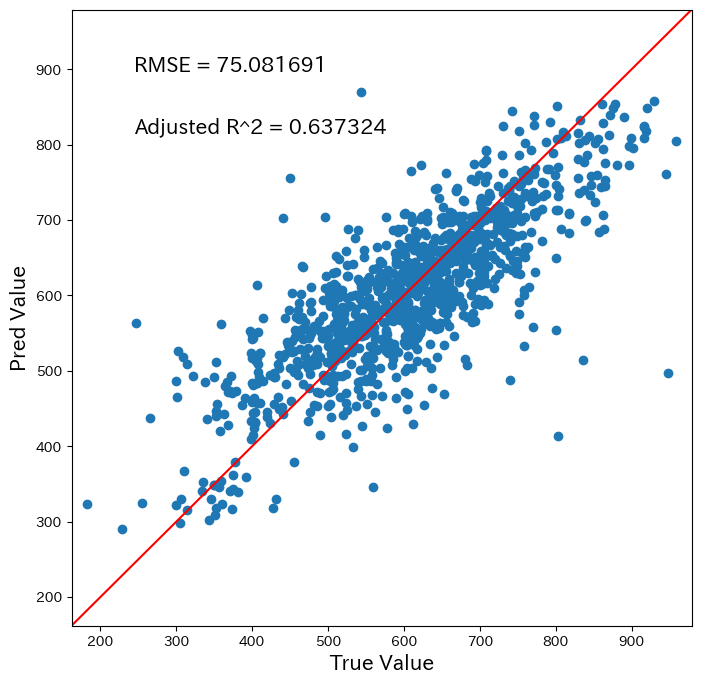

In [34]:
# 学習データ全体を用いてCatBoostモデルの再学習（モデル内部のbest_iterationを確認）
cat_final_model = CatBoostRegressor(**cat_best_params)
cat_final_model.fit(
    X_trainval, y_trainval,
    eval_set=(X_trainval, y_trainval),
    early_stopping_rounds=50
)

# クロスバリデーションのbest_iterationの平均値を計算
cat_mean_best_iter = int(np.mean(cat_best_iterations))
print(f"平均 best_iteration: {cat_mean_best_iter}")

# 学習全体およびクロスバリデーションのbest_iterationを用いてLightGBMモデルの再学習
cat_final_model = lgb.LGBMRegressor(**lgb_best_params, n_estimators=cat_mean_best_iter)
cat_final_model.fit(X_trainval, y_trainval)

# テストデータを用いて予測
y_test_pred = cat_final_model.predict(X_test)
cat_rmse_best = np.sqrt(mean_squared_error(y_test, y_test_pred))

# 可視化
def True_Pred_map(pred_df):
    RMSE = np.sqrt(mean_squared_error(pred_df['true'], pred_df['pred']))
    R2 = r2_score(pred_df['true'], pred_df['pred'])

    n = len(pred_df)
    k = X_train.shape[1]
    adjusted_R2 = 1 - (1 - R2) * (n - 1) / (n - k - 1)

    print(f'Best RMSE on test data: {cat_rmse_best}')
    print(f'Adjusted R-squared: {adjusted_R2}')

    plt.figure(figsize=(8, 8))
    ax = plt.subplot(111)
    ax.scatter('true', 'pred', data=pred_df)
    ax.set_xlabel('True Value', fontsize=15)
    ax.set_ylabel('Pred Value', fontsize=15)
    ax.set_xlim(pred_df.min().min() - 20, pred_df.max().max() + 20)
    ax.set_ylim(pred_df.min().min() - 20, pred_df.max().max() + 20)
    x = np.linspace(pred_df.min().min() - 20, pred_df.max().max() + 20, 2)
    ax.plot(x, x, 'r-')
    plt.text(0.1, 0.9, f'RMSE = {round(RMSE, 6)}', transform=ax.transAxes, fontsize=15)
    plt.text(0.1, 0.8, f'Adjusted R^2 = {round(adjusted_R2, 6)}', transform=ax.transAxes, fontsize=15)

# 予測値と真値を1つのデータフレームにまとめる
pred_df = pd.DataFrame({'true': y_test.reset_index(drop=True), 'pred': y_test_pred})

# 可視化関数の呼び出し
True_Pred_map(pred_df)

*7-4. HistGradientBoostingTree*

In [35]:
# Optunaの準備
def hgb_objective(trial):

    # ハイパーパラメータの探索範囲を設定
    hgb_params = {
        'loss': 'squared_error',
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'max_iter': trial.suggest_int('max_iter', 100, 2000),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
        'max_bins': trial.suggest_int('max_bins', 128, 255),
        'l2_regularization': trial.suggest_float('l2_regularization', 1e-8, 10.0, log=True),
        'early_stopping': True,
        'random_state': random_state,
        'verbose': False
    }

    # モデルを作成し学習
    hgb_model = HistGradientBoostingRegressor(**hgb_params)
    hgb_model.fit(X_train, y_train)

    # 検証データを用いてモデルの評価
    y_valid_pred = hgb_model.predict(X_valid)
    rmse = np.sqrt(mean_squared_error(y_valid, y_valid_pred))
    return rmse


# Optunaで最適ハイパーパラメータを探索
study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(hgb_objective, n_trials=150)

print("Number of finished trials:", len(study.trials))
print("Best trial:")

hgb_trial = study.best_trial
print(f"Value: {hgb_trial.value:.6f}")
print("Params:")
for key, value in hgb_trial.params.items():
    print(f"    {key}: {value}")

Number of finished trials: 150
Best trial:
Value: 75.631049
Params:
    learning_rate: 0.01683652423116018
    max_iter: 1758
    max_depth: 13
    min_samples_leaf: 14
    max_bins: 255
    l2_regularization: 2.8913016248090558e-08


In [36]:
# 最適ハイパーパラメータで再学習
hgb_best_params = hgb_trial.params
hgb_best_params.update({
    'max_iter': 1000,
    'loss': 'squared_error',  # RMSEに相当
    'early_stopping': True,
    'random_state': random_state,
    'verbose': 0
})

# クロスバリデーションの準備
kf = KFold(n_splits=5, shuffle=True, random_state=random_state)

hgb_oof_predictions = np.zeros(len(X_trainval))  # 各foldの検証データに対するOOF予測値を格納
hgb_test_predictions = np.zeros(len(X_test))  # テストデータに対する予測値を格納（各foldで平均化）
hgb_best_iterations = []  # 各foldの学習された最適イテレーション数を格納

for fold, (train_idx, val_idx) in enumerate(kf.split(X_trainval, y_trainval)):
    X_tr, X_val = X_trainval.iloc[train_idx], X_trainval.iloc[val_idx]
    y_tr, y_val = y_trainval.iloc[train_idx], y_trainval.iloc[val_idx]

    # モデルを作成し学習
    hgb_model = HistGradientBoostingRegressor(**hgb_best_params)
    hgb_model.fit(X_tr, y_tr)

    hgb_oof_predictions[val_idx] = hgb_model.predict(X_val)  # 検証データに対するOOF予測値を保存
    hgb_test_predictions += hgb_model.predict(X_test) / kf.n_splits  # テストデータに対する予測値を各foldで平均化
    hgb_best_iterations.append(hgb_model.n_iter_)  # 最適イテレーションを保存

# KFoldクロスバリデーションによるXGBoostのOOF予測値を用いた自由度調整済み決定係数
n = X_trainval.shape[0]  # サンプル数
k = np.sum(np.any(X_trainval.values != 0, axis=0))  # ゼロ行列ではない列をカウント
R2 = r2_score(y_trainval, hgb_oof_predictions)
adjusted_R2 = 1 - (1 - R2) * (n - 1) / (n - k - 1)
print(f"OOF Adjusted R²: {adjusted_R2:.6f}")

# 予測結果
submission = pd.DataFrame({'prediction': hgb_test_predictions})
print(submission.head())

OOF Adjusted R²: 0.641882
   prediction
0  471.246957
1  753.266072
2  579.015257
3  597.417257
4  576.791539


平均 best_iteration: 265
Best RMSE on test data: 75.8240338589102
Adjusted R-squared: 0.6301164814804632


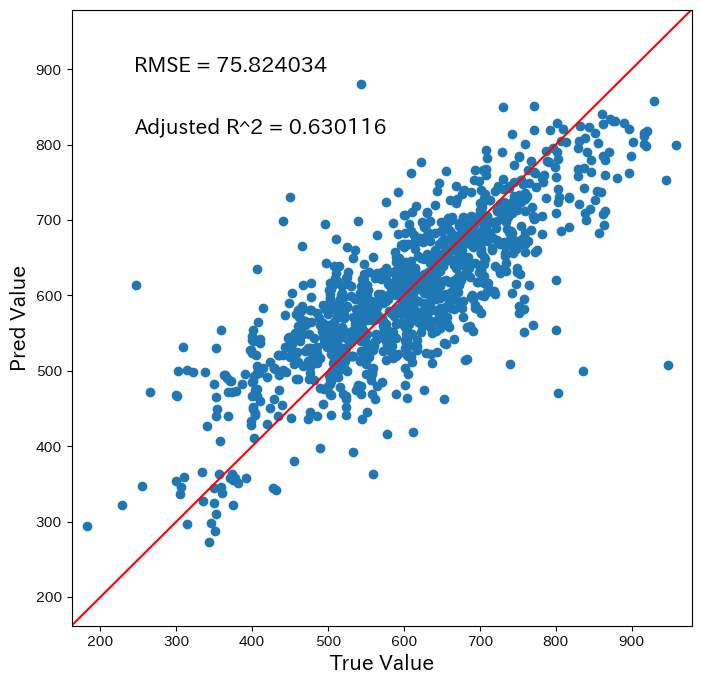

In [37]:
# 学習データ全体を用いてHistGradientBoostingTreeモデルの再学習（モデル内部のbest_iterationを確認）
hgb_model_final = HistGradientBoostingRegressor(**hgb_best_params)
hgb_model_final.fit(X_trainval, y_trainval)

# クロスバリデーションのbest_iterationの平均値を計算
hgb_mean_best_iter = int(np.mean(hgb_best_iterations))
print(f"平均 best_iteration: {hgb_mean_best_iter}")

# テストデータを用いて予測
y_test_pred = hgb_model_final.predict(X_test)
hgb_rmse_best = np.sqrt(mean_squared_error(y_test, y_test_pred))

# 可視化
def True_Pred_map(pred_df):
    RMSE = np.sqrt(mean_squared_error(pred_df['true'], pred_df['pred']))
    R2 = r2_score(pred_df['true'], pred_df['pred'])

    n = len(pred_df)
    k = X_train.shape[1]
    adjusted_R2 = 1 - (1 - R2) * (n - 1) / (n - k - 1)

    print(f'Best RMSE on test data: {hgb_rmse_best}')
    print(f'Adjusted R-squared: {adjusted_R2}')

    plt.figure(figsize=(8, 8))
    ax = plt.subplot(111)
    ax.scatter('true', 'pred', data=pred_df)
    ax.set_xlabel('True Value', fontsize=15)
    ax.set_ylabel('Pred Value', fontsize=15)
    ax.set_xlim(pred_df.min().min() - 20, pred_df.max().max() + 20)
    ax.set_ylim(pred_df.min().min() - 20, pred_df.max().max() + 20)
    x = np.linspace(pred_df.min().min() - 20, pred_df.max().max() + 20, 2)
    ax.plot(x, x, 'r-')
    plt.text(0.1, 0.9, f'RMSE = {round(RMSE, 6)}', transform=ax.transAxes, fontsize=15)
    plt.text(0.1, 0.8, f'Adjusted R^2 = {round(adjusted_R2, 6)}', transform=ax.transAxes, fontsize=15)

# 予測値と真値を1つのデータフレームにまとめる
pred_df = pd.DataFrame({'true': y_test.reset_index(drop=True), 'pred': y_test_pred})

# 可視化関数の呼び出し
True_Pred_map(pred_df)

*7-5. Random Forest*

In [38]:
# Optunaの準備
def rf_objective(trial):

    # ハイパーパラメータの探索範囲を設定
    rf_param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
        'random_state': random_state,
        'n_jobs': -1
    }

   # モデルを作成し学習
    rf_model = RandomForestRegressor(**rf_param)
    rf_model.fit(X_train, y_train)

    # 検証データを用いてモデルの評価
    y_valid_pred = rf_model.predict(X_valid)
    rmse = np.sqrt(mean_squared_error(y_valid, y_valid_pred))
    return rmse

# Optunaで最適ハイパーパラメータを探索
study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(rf_objective, n_trials=150)

print("Number of finished trials:", len(study.trials))
print("Best trial:")

rf_trial = study.best_trial
print(f"Value: {rf_trial.value:.6f}")
print("Params:")
for key, value in rf_trial.params.items():
    print(f"    {key}: {value}")

Number of finished trials: 150
Best trial:
Value: 76.967130
Params:
    n_estimators: 631
    max_depth: 19
    min_samples_split: 4
    min_samples_leaf: 1
    max_features: None
    bootstrap: True


In [39]:
# 最適パラメータで再学習
rf_best_params = rf_trial.params
rf_best_params.update({'random_state': random_state, 'n_jobs': -1})

# クロスバリデーションでOOF予測
kf = KFold(n_splits=5, shuffle=True, random_state=random_state)

rf_oof_predictions = np.zeros(len(X_trainval))# 各foldの検証データに対するOOF予測値を格納
rf_test_predictions = np.zeros(len(X_test))# テストデータに対する予測値を格納（各foldで平均化）

for fold, (train_idx, val_idx) in enumerate(kf.split(X_trainval, y_trainval)):
    X_tr, X_val = X_trainval.iloc[train_idx], X_trainval.iloc[val_idx]
    y_tr, y_val = y_trainval.iloc[train_idx], y_trainval.iloc[val_idx]

    rf_model = RandomForestRegressor(**rf_best_params)
    rf_model.fit(X_tr, y_tr)

    rf_oof_predictions[val_idx] = rf_model.predict(X_val)  # 検証データに対するOOF予測値を保存
    rf_test_predictions += rf_model.predict(X_test) / kf.n_splits  # テストデータに対する予測値を各foldで平均化

# KFoldクロスバリデーションによるLightGBMのOOF予測値を用いた自由度調整済み決定係数
n = X_trainval.shape[0]  # サンプル数
k = np.sum(np.any(X_trainval.values != 0, axis=0))  # 特徴量数
R2 = r2_score(y_trainval, rf_oof_predictions)
adjusted_R2 = 1 - (1 - R2) * (n - 1) / (n - k - 1)
print(f"OOF Adjusted R²: {adjusted_R2:.6f}")

# テストデータに対する予測値を出力
submission = pd.DataFrame({'prediction': rf_test_predictions})
print(submission.head())

OOF Adjusted R²: 0.620135
   prediction
0  471.442050
1  771.818621
2  539.772984
3  605.532359
4  593.125071


Best RMSE on test data: 78.10029097131248
Adjusted R-squared: 0.6075751387279741


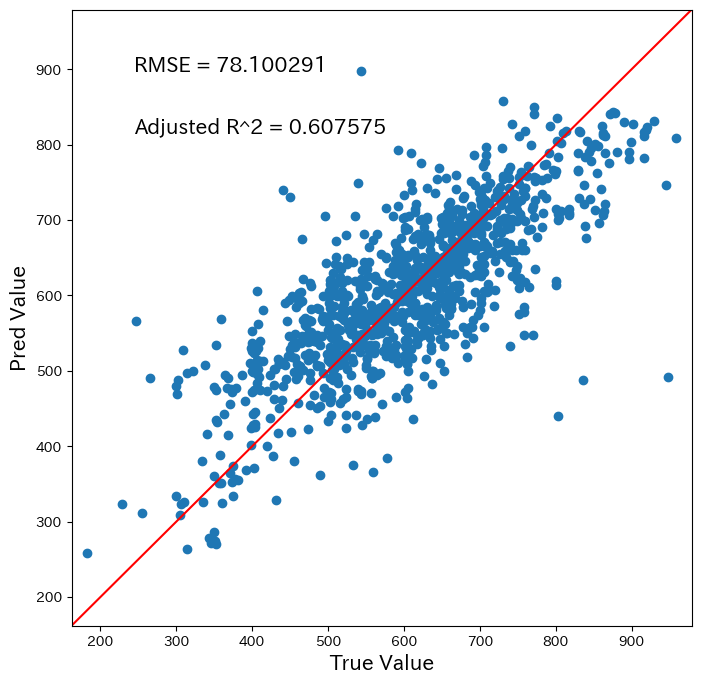

In [40]:
# 学習データ全体を用いてRandomForestモデルの再学習（モデル内部のbest_iterationを確認）
rf_model_final = RandomForestRegressor(**rf_best_params)
rf_model_final.fit(X_trainval, y_trainval)

# テストデータを用いて予測
y_test_pred = rf_model_final.predict(X_test)
rf_rmse_best = np.sqrt(mean_squared_error(y_test, y_test_pred))

# 可視化
def True_Pred_map(pred_df):
    RMSE = np.sqrt(mean_squared_error(pred_df['true'], pred_df['pred']))
    R2 = r2_score(pred_df['true'], pred_df['pred'])

    n = len(pred_df)
    k = X_train.shape[1]
    adjusted_R2 = 1 - (1 - R2) * (n - 1) / (n - k - 1)

    print(f'Best RMSE on test data: {rf_rmse_best}')
    print(f'Adjusted R-squared: {adjusted_R2}')

    plt.figure(figsize=(8, 8))
    ax = plt.subplot(111)
    ax.scatter('true', 'pred', data=pred_df)
    ax.set_xlabel('True Value', fontsize=15)
    ax.set_ylabel('Pred Value', fontsize=15)
    ax.set_xlim(pred_df.min().min() - 20, pred_df.max().max() + 20)
    ax.set_ylim(pred_df.min().min() - 20, pred_df.max().max() + 20)
    x = np.linspace(pred_df.min().min() - 20, pred_df.max().max() + 20, 2)
    ax.plot(x, x, 'r-')
    plt.text(0.1, 0.9, f'RMSE = {round(RMSE, 6)}', transform=ax.transAxes, fontsize=15)
    plt.text(0.1, 0.8, f'Adjusted R^2 = {round(adjusted_R2, 6)}', transform=ax.transAxes, fontsize=15)

# 予測値と真値を1つのデータフレームにまとめる
pred_df = pd.DataFrame({'true': y_test.reset_index(drop=True), 'pred': y_test_pred})

# 可視化関数の呼び出し
True_Pred_map(pred_df)

*7-6. Model Performance Comparison*

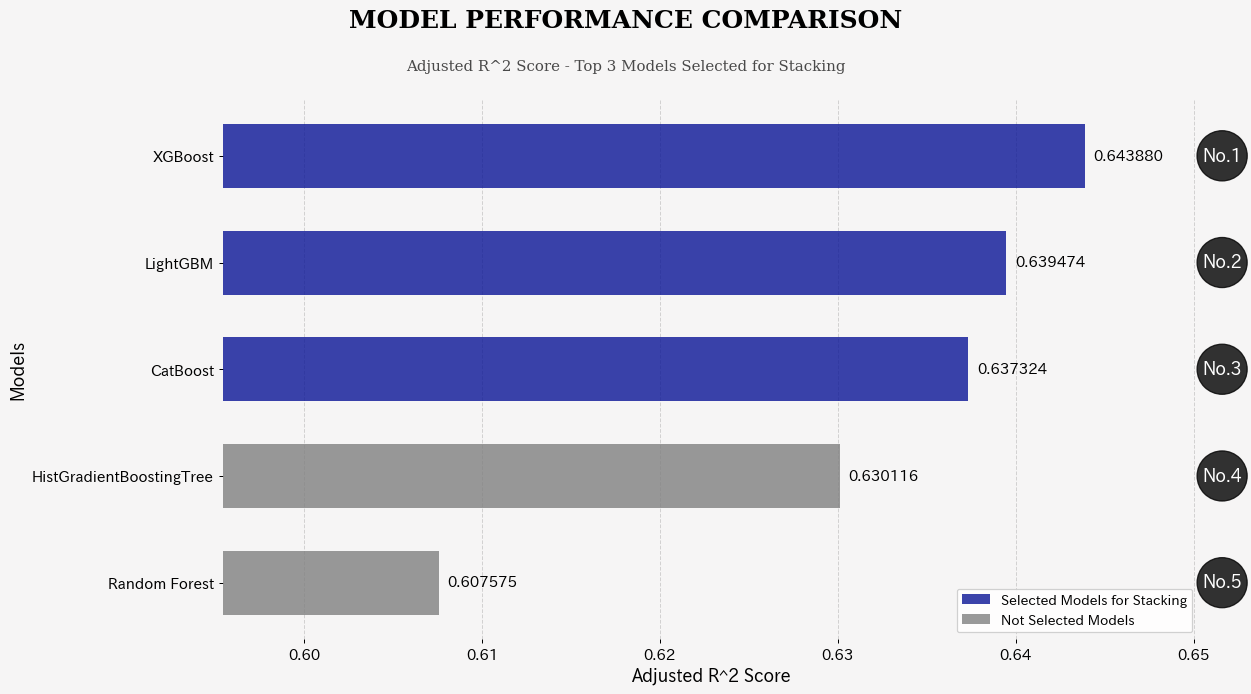

# MODEL COMPARISON SUMMARY
# ==================================================
# Top Performer:    XGBoost (0.643880)
# Second Best:      LightGBM (0.639474)
# Third Best:       CatBoost (0.637324)
# Selected Models:  XGBoost, LightGBM, CatBoost
# ==================================================


In [41]:
# 棒グラフの設定
fig = plt.figure(figsize=(14, 8), dpi=90)
fig.patch.set_facecolor('#f6f5f5')

ax = plt.subplot()
ax.set_facecolor('#f6f5f5')

models = [
    'XGBoost',
    'LightGBM',
    'CatBoost',
    'HistGradientBoostingTree',
    'Random Forest'
    ]

scores = [
    0.643880,
    0.639474,
    0.637324,
    0.630116,
    0.607575
    ]

colors = [
    '#0a1496',
    '#0a1496',
    '#0a1496',
    'grey',
    'grey'
    ]

bars = ax.barh(models, scores, color=colors, alpha=0.8, height=0.6)

ax.set_xlabel('Adjusted R^2 Score', fontsize=14, fontweight='bold', color='black')
ax.set_ylabel('Models', fontsize=14, fontweight='bold', color='black')

for i, (bar, score) in enumerate(zip(bars, scores)):
    ax.text(score + 0.0005, bar.get_y() + bar.get_height()/2,
            f'{score:.6f}', ha='left', va='center', fontweight='bold',
            fontsize=12, color='black')

for i, (bar, rank) in enumerate(zip(bars, range(1, 6))):
    ax.text(max(scores)*1.012, bar.get_y() + bar.get_height()/2,
            f'No.{rank}', ha='center', va='center', fontweight='bold',
            fontsize=14, color='white',
            bbox=dict(boxstyle='circle', facecolor='black', alpha=0.8))

ax.grid(axis='x', alpha=0.3, linestyle='--', color='gray')
ax.set_axisbelow(True)
for spine in ax.spines.values():
    spine.set_visible(False)

ax.set_xlim(min(scores)*0.98, max(scores)*1.01)

ax.tick_params(axis='both', labelsize=12, colors='black')

ax.invert_yaxis()

fig.text(0.5, 0.95, 'MODEL PERFORMANCE COMPARISON',
         {'font':'serif', 'size':20, 'weight':'bold','color':'black'}, ha='center')

fig.text(0.5, 0.89, 'Adjusted R^2 Score - Top 3 Models Selected for Stacking',
         {'font':'serif', 'size':12,'color':'black'}, alpha=0.7, ha='center')


legend_elements = [
    plt.Rectangle((1,0),1,1, facecolor='#0a1496', alpha=0.8, label='Selected Models for Stacking'),
    plt.Rectangle((1,0),1,1, facecolor='grey', alpha=0.8, label='Not Selected Models')
]
ax.legend(handles=legend_elements, loc='lower right', fontsize=11, framealpha=0.9)


best_score = max(scores)
worst_score = min(scores)
score_range = best_score - worst_score
mean_score = np.mean(scores)

plt.tight_layout()
plt.subplots_adjust(bottom=0.1, top=0.85)
plt.show()

print("# MODEL COMPARISON SUMMARY")
print("# " + "="*50)
print(f"# Top Performer:    {models[0]} ({scores[0]:.6f})")
print(f"# Second Best:      {models[1]} ({scores[1]:.6f})")
print(f"# Third Best:       {models[2]} ({scores[2]:.6f})")
print(f"# Selected Models:  XGBoost, LightGBM, CatBoost")
print("# " + "="*50)

**8. Stacking Ensemble - Top 3 Models**

In [42]:
# 自由度調整済み決定係数を計算する関数
def adjusted_r2(y_true, y_pred, p):
    n = len(y_true)
    r2 = r2_score(y_true, y_pred)
    return 1 - (1 - r2) * (n - 1) / (n - p - 1)

# データ準備
stacking_train = pd.DataFrame({
    'lgb': lgb_oof_predictions,
    'xgb': xgb_oof_predictions,
    'cat': cat_oof_predictions
})

stacking_test = pd.DataFrame({
    'lgb': lgb_test_predictions,
    'xgb': xgb_test_predictions,
    'cat': cat_test_predictions
})

p = stacking_train.shape[1]  # 特徴量の数（モデル数）

*8-1. Weighted Average Ensemble*

In [43]:
weights = np.array([
    adjusted_r2(y_trainval, lgb_oof_predictions, 1),
    adjusted_r2(y_trainval, xgb_oof_predictions, 1),
    adjusted_r2(y_trainval, cat_oof_predictions, 1)
])
weights /= weights.sum()  # 正規化

weighted_oof = (stacking_train * weights).sum(axis=1)
weighted_test = (stacking_test * weights).sum(axis=1)

adj_r2_weighted_oof = adjusted_r2(y_trainval, weighted_oof, p)
adj_r2_weighted_test = adjusted_r2(y_test, weighted_test, p)

print(f"Weighted Average Adjusted R² (OOF): {adj_r2_weighted_oof:.6f}")
print(f"Weighted Average Adjusted R² (Test): {adj_r2_weighted_test:.6f}")

Weighted Average Adjusted R² (OOF): 0.660730
Weighted Average Adjusted R² (Test): 0.645018


*8-2. Simple Average Ensemble*

In [44]:
simple_oof = stacking_train.mean(axis=1)
simple_test = stacking_test.mean(axis=1)

adj_r2_simple_oof = adjusted_r2(y_trainval, simple_oof, p)
adj_r2_simple_test = adjusted_r2(y_test, simple_test, p)
print(f"Simple Average Adjusted R² (OOF): {adj_r2_simple_oof:.6f}")
print(f"Simple Average Adjusted R² (Test): {adj_r2_simple_test:.6f}")

Simple Average Adjusted R² (OOF): 0.660727
Simple Average Adjusted R² (Test): 0.645016


*8-3. Linear Regression Ensemble*

In [45]:
meta_learner = LinearRegression()
meta_learner.fit(stacking_train, y_trainval)

meta_oof = meta_learner.predict(stacking_train)
meta_test = meta_learner.predict(stacking_test)

adj_r2_meta_oof = adjusted_r2(y_trainval, meta_oof, p)
adj_r2_meta_test = adjusted_r2(y_test, meta_test, p)

print(f"Meta-learner Adjusted R² (OOF): {adj_r2_meta_oof:.6f}")
print(f"Meta-learner Adjusted R² (Test): {adj_r2_meta_test:.6f}")

Meta-learner Adjusted R² (OOF): 0.661284
Meta-learner Adjusted R² (Test): 0.644172


*8-4. All Model Performance Comparison*

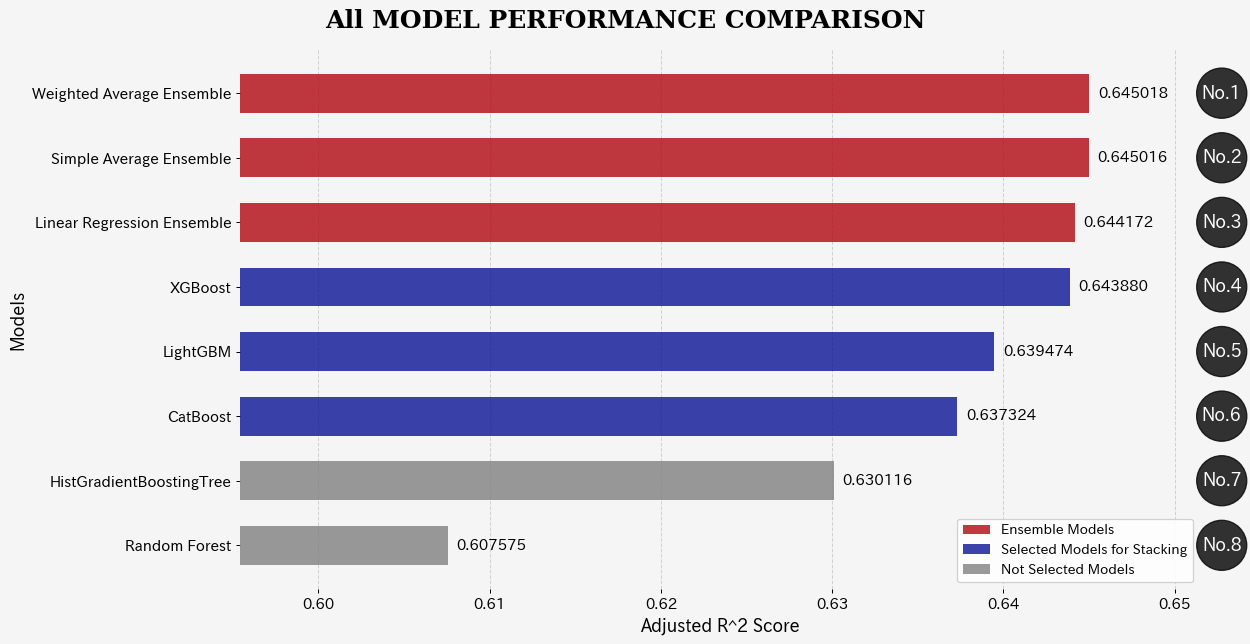

# All MODEL COMPARISON SUMMARY
# ====================================================================================================
# Top Performer:    Weighted Average Ensemble (0.645018)
# Second Best:      Simple Average Ensemble (0.645016)
# Third Best:       Linear Regression Ensemble (0.644172)
# ====================================================================================================


In [46]:
# 棒グラフの設定
fig = plt.figure(figsize=(14, 8), dpi=90)
fig.patch.set_facecolor('#f6f5f5')

ax = plt.subplot()
ax.set_facecolor('#f6f5f5')

models = [
    'Weighted Average Ensemble',
    'Simple Average Ensemble',
    'Linear Regression Ensemble',
    'XGBoost',
    'LightGBM',
    'CatBoost',
    'HistGradientBoostingTree',
    'Random Forest'
    ]

scores = [
    0.645018,
    0.645016,
    0.644172,
    0.643880,
    0.639474,
    0.637324,
    0.630116,
    0.607575
    ]

colors = [
    '#b20710',
    '#b20710',
    '#b20710',
    '#0a1496',
    '#0a1496',
    '#0a1496',
    'grey',
    'grey'
    ]

bars = ax.barh(models, scores, color=colors, alpha=0.8, height=0.6)

ax.set_xlabel('Adjusted R^2 Score', fontsize=14, fontweight='bold', color='black')
ax.set_ylabel('Models', fontsize=14, fontweight='bold', color='black')

for i, (bar, score) in enumerate(zip(bars, scores)):
    ax.text(score + 0.0005, bar.get_y() + bar.get_height()/2,
            f'{score:.6f}', ha='left', va='center', fontweight='bold',
            fontsize=12, color='black')

for i, (bar, rank) in enumerate(zip(bars, range(1, 9))):
    ax.text(max(scores)*1.012, bar.get_y() + bar.get_height()/2,
            f'No.{rank}', ha='center', va='center', fontweight='bold',
            fontsize=14, color='white',
            bbox=dict(boxstyle='circle', facecolor='black', alpha=0.8))

ax.grid(axis='x', alpha=0.3, linestyle='--', color='gray')
ax.set_axisbelow(True)
for spine in ax.spines.values():
    spine.set_visible(False)

ax.set_xlim(min(scores)*0.98, max(scores)*1.01)

ax.tick_params(axis='both', labelsize=12, colors='black')

ax.invert_yaxis()

fig.text(0.5, 0.88, 'All MODEL PERFORMANCE COMPARISON',
         {'font':'serif', 'size':20, 'weight':'bold', 'color':'black'}, ha='center')

legend_elements = [
    plt.Rectangle((1,0),1,1, facecolor='#b20710', alpha=0.8, label='Ensemble Models'),
    plt.Rectangle((1,0),1,1, facecolor='#0a1496', alpha=0.8, label='Selected Models for Stacking'),
    plt.Rectangle((1,0),1,1, facecolor='grey', alpha=0.8, label='Not Selected Models')
]
ax.legend(handles=legend_elements, loc='lower right', fontsize=11, framealpha=0.9)


best_score = max(scores)
worst_score = min(scores)
score_range = best_score - worst_score
mean_score = np.mean(scores)

plt.tight_layout()
plt.subplots_adjust(bottom=0.1, top=0.85)
plt.show()

print("# All MODEL COMPARISON SUMMARY")
print("# " + "="*100)
print(f"# Top Performer:    {models[0]} ({scores[0]:.6f})")
print(f"# Second Best:      {models[1]} ({scores[1]:.6f})")
print(f"# Third Best:       {models[2]} ({scores[2]:.6f})")
print("# " + "="*100)